In [ ]:
! pip install pydantic
! pip install PyYAML
! pip install numpy==1.26.4
! pip install torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2
! pip install --no-cache-dir dgl -f https://data.dgl.ai/wheels/repo.html
! pip install dill
! pip install torchdata==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.

In [ ]:
import pandas as pd
import torch
import dgl.sparse as dglsp
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
df=pd.read_excel('/content/drive/MyDrive/Graph_Research/filtered_dataset.xlsx')

In [ ]:
df['concept'] = df['concept'].astype(str)
df['paper_id'] = df['paper_id'].astype(str)

In [ ]:
datadir = '/content/drive/MyDrive/Graph_Research'
max_groupsize = 169
import pickle

# Load the vertex embeddings from the file
with open(datadir + '/vertex_embeddings3_' + str(max_groupsize) + '.p', 'rb') as fp:
    vertex_data = pickle.load(fp)
node_ids = vertex_data["ids"]
node_embeddings = vertex_data["embeddings"]

In [ ]:
with open(datadir + '/hyperedge_embeddings3_' + str(max_groupsize) + '.p', 'rb') as fp:
    hyperedge_data = pickle.load(fp)
hyperedge_ids=hyperedge_data["ids"]
hyperedge_embeddings=hyperedge_data["embeddings"]

In [ ]:
def create_incidence_matrix(df):
  concept_to_idx={word:node_ids.index(word) for word in list(df['concept'].unique())}
  paper_to_idx={str(paper_id):hyperedge_ids.index(paper_id) for paper_id in list(df['paper_id'].unique())}

  rows=[]
  cols=[]
  for _, row in df.iterrows():
    concept_idx=concept_to_idx[row['concept']]
    paper_idx=paper_to_idx[row['paper_id']]
    rows.append(concept_idx)
    cols.append(paper_idx)
  rows=torch.tensor(rows)
  cols=torch.tensor(cols)

  H=dglsp.spmatrix(torch.stack([rows,cols]))
  return H, concept_to_idx

H, concept_to_idx_train = create_incidence_matrix(df)

In [ ]:
H.to_dense()

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])

In [ ]:
def generate_positive_samples(df, max_len=16):
    """Generates positive samples (keyword sets that form real hyperedges) from the dataframe."""
    positive_samples = df.groupby('paper_id')['concept'].apply(list).tolist()

    positive_samples_indices = [[node_ids.index(word) if word in node_ids else -1 for word in sublist] for sublist in positive_samples]
    positive_samples_indices = [[word_index for word_index in sample if word_index != -1] for sample in positive_samples_indices]

    #Pad or truncate to ensure consistent length
    padded_samples = []
    for sample in positive_samples_indices:
        if len(sample) < max_len:
            # Pad with zeros
            padded_samples.append(sample + [-1] * (max_len - len(sample))) # Padding with zeros
        elif len(sample) > max_len:
            # Truncate
            padded_samples.append(sample[:max_len])
        else:
            padded_samples.append(sample)

    return torch.tensor(padded_samples, dtype=torch.long)

In [ ]:
def generate_negative_samples(df, num_samples, max_len=16):

    negative_samples = []
    positive_samples_list = [list(row) for row in df.groupby('paper_id')['concept'].apply(list).tolist()]  # Positive samples as list of lists

    while len(negative_samples) < num_samples:
        # Randomly select a set of keywords and ensure it’s not in positive_samples
        neg_sample_concepts = random.sample(node_ids, random.randint(10,16))
        if neg_sample_concepts not in positive_samples_list:
            # Convert concepts to their indices
            neg_sample_indices = [node_ids.index(word) for word in neg_sample_concepts]

            # Pad or truncate to max_len
            if len(neg_sample_indices) < max_len:
                # Pad with zeros
                neg_sample_indices += [-1] * (max_len - len(neg_sample_indices))
            elif len(neg_sample_indices) > max_len:
                # Truncate to max_len
                neg_sample_indices = neg_sample_indices[:max_len]

            negative_samples.append(neg_sample_indices)

    return torch.tensor(negative_samples, dtype=torch.long)

In [ ]:
from sklearn.model_selection import train_test_split

# Generate positive and negative samples
positive_samples = generate_positive_samples(df, max_len=16)
negative_samples = generate_negative_samples(df, num_samples=len(positive_samples), max_len=16)

# Create labels
positive_labels = torch.ones(len(positive_samples), dtype=torch.long)  # Label 1 for positive samples
negative_labels = torch.zeros(len(negative_samples), dtype=torch.long)  # Label 0 for negative samples

# Combine samples and labels
all_samples = torch.cat([positive_samples, negative_samples], dim=0)
all_labels = torch.cat([positive_labels, negative_labels], dim=0)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_samples, all_labels, test_size=0.3, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Print dataset sizes
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 10677 samples
Validation set: 2288 samples
Test set: 2289 samples


In [ ]:
def compute_hypergraph_laplacian(H):
    """
    Compute the normalized Laplacian for a hypergraph.

    Args:
        H (torch.Tensor): Incidence matrix of shape (num_nodes, num_hyperedges).

    Returns:
        torch.Tensor: Hypergraph Laplacian of shape (num_nodes, num_nodes).
    """
    # Compute node degree matrix (D_v)
    D_v = torch.diag(torch.sum(H, dim=1))

    # Compute hyperedge degree matrix (D_e)
    D_e = torch.diag(torch.sum(H, dim=0))

    # Compute D_v^(-1/2) and D_e^(-1)
    D_v_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.sum(H, dim=1)))
    D_e_inv = torch.diag(1.0 / torch.sum(H, dim=0))

    # Avoid division by zero
    D_v_inv_sqrt[torch.isinf(D_v_inv_sqrt)] = 0
    D_e_inv[torch.isinf(D_e_inv)] = 0

    # Compute Laplacian: L = I - D_v^(-1/2) H D_e^(-1) H^T D_v^(-1/2)
    identity = torch.eye(H.shape[0])  # Identity matrix
    L = identity - D_v_inv_sqrt @ H @ D_e_inv @ H.T @ D_v_inv_sqrt

    return L

# Example usage
num_nodes = 5
num_hyperedges = 3

# Random binary incidence matrix (nodes x hyperedges)
#H.to_dense() = torch.tensor(H, dtype=torch.float)

L = compute_hypergraph_laplacian(H.to_dense())
print("Hypergraph Laplacian:\n", L)

Hypergraph Laplacian:
 tensor([[ 0.9390, -0.0018, -0.0027,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0018,  0.9435, -0.0049,  ...,  0.0000,  0.0000, -0.0031],
        [-0.0027, -0.0049,  0.9434,  ..., -0.0018, -0.0010,  0.0000],
        ...,
        [ 0.0000,  0.0000, -0.0018,  ...,  0.9410,  0.0000,  0.0000],
        [ 0.0000,  0.0000, -0.0010,  ...,  0.0000,  0.9607,  0.0000],
        [ 0.0000, -0.0031,  0.0000,  ...,  0.0000,  0.0000,  0.9597]])


In [ ]:
D_v = torch.diag(torch.sum(H.to_dense(), dim=1))
print(D_v.shape)
print(H.to_dense().shape)

torch.Size([5362, 5362])
torch.Size([5362, 7627])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HyperGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, num_layers=2):
        """
        HyperGCN for hypergraphs.
        Args:
            input_dim (int): Input feature dimensionality.
            hidden_dim (int): Hidden layer dimensionality.
            out_dim (int): Output dimensionality.
            num_layers (int): Number of GCN layers.
        """
        super(HyperGCN, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim if i < num_layers - 1 else out_dim)
            for i in range(num_layers)
        ])
        self.output_layer = nn.Linear(hidden_dim, hidden_dim)
        self.scoring_layer=nn.Linear(hidden_dim,1)

    def forward(self, node_embeddings, laplacian, candidate_hyperedges):
        """
        Forward pass of HyperGCN.
        Args:
            node_embeddings (torch.Tensor): Initial node embeddings [num_nodes, input_dim].
            laplacian (torch.Tensor): Normalized hypergraph Laplacian [num_nodes, num_nodes].
        Returns:
            torch.Tensor: Updated node embeddings.
        """
        x = node_embeddings
        for layer in self.layers[:-1]:
            x = F.relu(layer(torch.matmul(laplacian, x)))  # Apply Laplacian and non-linearity
        x = self.layers[-1](torch.matmul(laplacian, x))  # Final layer without activation
        #return F.log_softmax(x, dim=1)
        node_embeddings=F.log_softmax(x, dim=1)
        #return node_embeddings
        # Final layer for node embeddings
        final_node_embeddings=self.output_layer(node_embeddings)

        # Gather embeddings for each candidate hyperedge
        candidate_node_embeddings = final_node_embeddings[candidate_hyperedges]  # Shape: [num_hyperedges, max_len, embedding_dim]

        # Calculate mean embeddings for each hyperedge
        hyperedge_embs = candidate_node_embeddings.mean(dim=1)  # Mean across nodes in each hyperedge

        # Score candidate hyperedges
        scores = self.scoring_layer(hyperedge_embs).squeeze(dim=-1)
        scores = scores.sigmoid()  # Convert to probabilities between 0 and 1
        return scores


# Example usage
num_nodes = 100
input_dim = 16
hidden_dim = 32
out_dim = 32

#node_embeddings = torch.rand(num_nodes, input_dim)  # Random node embeddings
#laplacian = torch.eye(num_nodes) - torch.rand(num_nodes, num_nodes) * 0.1  # Approximate Laplacian
#laplacian = compute_hypergraph_laplacian(H)

model = HyperGCN(input_dim, hidden_dim, out_dim)
#output = model(node_embeddings, L, can)
#print("HyperGCN Output Shape:", output.shape)


In [ ]:
import torch

# Assuming 'H' is your sparse hypergraph incidence matrix
def H_dense():
    """
    Converts the sparse hypergraph incidence matrix 'H' to a dense tensor.
    """
    # Make sure H is a sparse tensor before calling to_dense()
    if not isinstance(H, torch.Tensor):
        raise TypeError("H must be a torch.Tensor")
    if not H.is_sparse:
        raise ValueError("H must be a sparse tensor")
    return H.to_dense()

# Rest of your code (including the training loop)...

In [ ]:
node_embeddings=torch.tensor(node_embeddings, dtype=torch.float32)

<ipython-input-45-68d74781d0cd>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_embeddings=torch.tensor(node_embeddings, dtype=torch.float32)


In [ ]:
node_embeddings.shape

torch.Size([5362, 16])

In [ ]:
predictions = model(node_embeddings, L, X_train)

In [ ]:
predictions.shape

torch.Size([])

In [ ]:
import torch.optim as optim
learning_rate = 0.001
num_epochs = 150

# Initialize model, loss, and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
node_embeddings=torch.tensor(node_embeddings, dtype=torch.float32)
train_losses=[]
val_losses=[]
# Training and Validation Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    predictions = model(node_embeddings, L, X_train)  # Forward pass
    train_loss = criterion(predictions, y_train.float())  # Compute loss
    train_loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_predictions = model(node_embeddings, L, X_val)
        val_loss = criterion(val_predictions, y_val.float())
        val_accuracy = ((val_predictions >= 0.5) == y_val).float().mean().item()

    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

    # Print epoch results
    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_loss.item():.4f}, "
        f"Val Loss: {val_loss.item():.4f}, "
        f"Val Accuracy: {val_accuracy:.4f}"
    )

Epoch 1/150, Train Loss: 1.0436, Val Loss: 0.9135, Val Accuracy: 0.5000
Epoch 2/150, Train Loss: 0.9133, Val Loss: 0.8088, Val Accuracy: 0.5000
Epoch 3/150, Train Loss: 0.8086, Val Loss: 0.7348, Val Accuracy: 0.5000
Epoch 4/150, Train Loss: 0.7347, Val Loss: 0.6941, Val Accuracy: 0.5000
Epoch 5/150, Train Loss: 0.6941, Val Loss: 0.6841, Val Accuracy: 0.5000
Epoch 6/150, Train Loss: 0.6842, Val Loss: 0.6957, Val Accuracy: 0.5000
Epoch 7/150, Train Loss: 0.6959, Val Loss: 0.7158, Val Accuracy: 0.5000
Epoch 8/150, Train Loss: 0.7160, Val Loss: 0.7326, Val Accuracy: 0.5000
Epoch 9/150, Train Loss: 0.7329, Val Loss: 0.7401, Val Accuracy: 0.5000
Epoch 10/150, Train Loss: 0.7405, Val Loss: 0.7371, Val Accuracy: 0.5000
Epoch 11/150, Train Loss: 0.7376, Val Loss: 0.7259, Val Accuracy: 0.5000
Epoch 12/150, Train Loss: 0.7264, Val Loss: 0.7097, Val Accuracy: 0.5000
Epoch 13/150, Train Loss: 0.7103, Val Loss: 0.6924, Val Accuracy: 0.5000
Epoch 14/150, Train Loss: 0.6930, Val Loss: 0.6771, Val Accu

In [ ]:
# Test phase
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for testing
    test_predictions = model(node_embeddings, L, X_test)  # Forward pass for test data
    test_loss = criterion(test_predictions, y_test.float())  # Compute loss for test data
    test_accuracy = ((test_predictions >= 0.5) == y_test).float().mean().item()  # Calculate accuracy

# Print test results
print(
    f"Test Loss: {test_loss.item():.4f}, "
    f"Test Accuracy: {test_accuracy:.4f}"
)


Test Loss: 0.0848, Test Accuracy: 0.9755


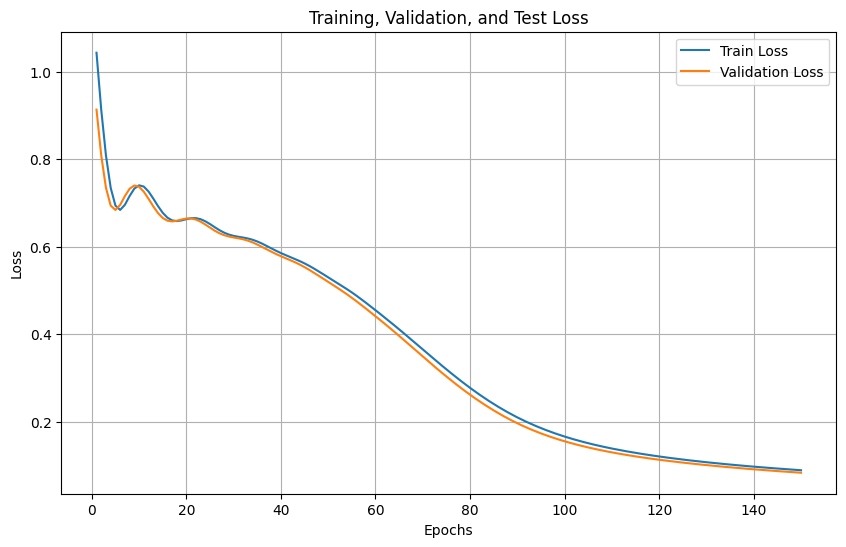

In [ ]:
import matplotlib.pyplot as plt
#print(f"Test Loss: {test_loss:.4f}")

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
#plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Test loss as a horizontal line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1145
           1       0.99      0.96      0.98      1144

    accuracy                           0.98      2289
   macro avg       0.98      0.98      0.98      2289
weighted avg       0.98      0.98      0.98      2289



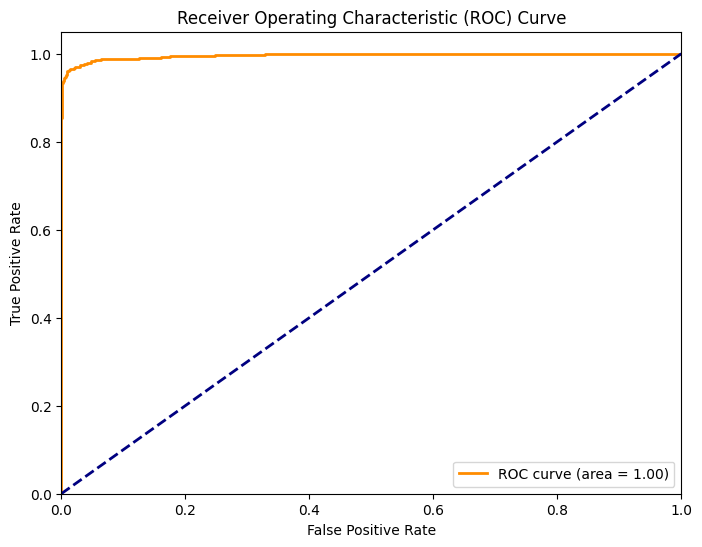

Test Loss: 0.0848
Precision: 0.9892
Recall: 0.9615
F1 Score: 0.9752


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_predictions = model(node_embeddings, L, X_test)  # Forward pass on test set
    test_loss = criterion(test_predictions, y_test.float())  # Calculate test loss
    test_predictions_bin = (test_predictions >= 0.5).long()  # Convert predictions to binary labels (0 or 1)

    # Calculate precision, recall, f1 score
    precision = precision_score(y_test, test_predictions_bin)
    recall = recall_score(y_test, test_predictions_bin)
    f1 = f1_score(y_test, test_predictions_bin)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, test_predictions_bin))

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, test_predictions.cpu())  # True positive rate vs false positive rate
    roc_auc = auc(fpr, tpr)  # Calculate the area under the ROC curve

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Print test loss and other metrics
print(f"Test Loss: {test_loss.item():.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
